# Torch
## Check GPU¶

In [1]:
import torch
import numpy as np
import sys
sys.path.append('..')

from torchlib.utils import list_device,set_device

# S1: check GPU
#list_device()

# S2: default parameters
set_device(1)
np.set_printoptions(precision = 2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


Using Device 1 : TITAN Xp


In [2]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()

'''Training Parameters'''
parser.add_argument('--batch_size', type=int, default=280, help='minibatch size')
parser.add_argument('--num_epochs', type=int, default=200, help='number of epochs')
parser.add_argument('--grad_clip', type=float, default=5., help='clip gradients at this value')
parser.add_argument('--learning_rate', type=float, default=0.08, help='learning rate')
parser.add_argument('--learning_rate_clip', type=float, default=0.0000001, help='learning rate clip')
parser.add_argument('--decay_rate', type=float, default=.7, help='decay rate for rmsprop')
parser.add_argument('--weight_decay', type=float, default=.0001, help='decay rate for rmsprop')
parser.add_argument('--batch_norm_decay', type=float, default=.999, help='decay rate for rmsprop')
parser.add_argument('--keep_prob', type=float, default=1.0, help='dropout keep probability')
parser.add_argument('--lamda_weights', type=float, default=.01, help='lamda weight')
parser.add_argument('--data_argumentation', type=bool, default=True, help='whether do data argument')
parser.add_argument('--is_normalization', type=bool, default=True, help='whether do data nomalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int, help='Input images will be resized to this for data argumentation.')
parser.add_argument('--output_dim', default=3, type=int, help='output dimention.')
parser.add_argument('--feat_dim', default=128, type=int, help='feature dimention.')

'''Configure'''
parser.add_argument('--network', type=str, default='vggnet_localization')
parser.add_argument('--model_dir', type=str, default='/notebooks/global_localization/class_gps_torch', help='rnn, gru, or lstm')

parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/2012_01_08',
                                                            '/notebooks/michigan_nn_data/2012_01_15',
                                                            '/notebooks/michigan_nn_data/2012_01_22',
                                                            '/notebooks/michigan_nn_data/2012_02_02',
                                                            '/notebooks/michigan_nn_data/2012_02_04',
                                                            '/notebooks/michigan_nn_data/2012_02_05',
                                                            '/notebooks/michigan_nn_data/2012_03_31',
                                                            '/notebooks/michigan_nn_data/2012_09_28'])
'''
#parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/test'])
parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/2012_01_08'])
'''
parser.add_argument('--norm_tensor', type=str, default = ['/notebooks/global_localization/norm_mean_std.pt'])

parser.add_argument('--seed', default=1337, type=int)
parser.add_argument('--save_every', type=int, default=1000, help='save frequency')
parser.add_argument('--display', type=int, default=10, help='display frequency')
parser.add_argument('--tensorboard', type=bool, default=True, help='open tensorboard')

sys.argv = ['']
args = parser.parse_args()

# Load Dataset

In [3]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tf.transformations as tf_tran
from tqdm import tqdm
from PIL import Image
import numpy as np
import random

import gpytorch

import torch.nn as nn
import torch.optim as optim
from torchlib import resnet, vggnet
from torchlib.cnn_auxiliary import normalize, denormalize_navie, denormalize, get_relative_pose, translational_rotational_loss
from torchlib.utils import LocalizationDataset, display_loss, data2tensorboard
import time

transform = transforms.Compose([transforms.ToTensor()])
dataset = LocalizationDataset(dataset_dirs = args.train_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, get_pair = False)

if len(args.train_dataset)>7:
    [args.norm_mean, args.norm_std] = [torch.tensor(x) for x in dataset.get_norm()]
    torch.save([args.norm_mean, args.norm_std], *args.norm_tensor)
    print('Save norm and std:',*args.norm_tensor)
else:
    [args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)
    print('Load norm and std:',*args.norm_tensor)


dataloader = DataLoader(dataset, batch_size=args.batch_size, \
                        shuffle=True, num_workers=0, \
                        drop_last=True, pin_memory=False)

100%|██████████| 14037/14037 [00:25<00:00, 545.16it/s]


Save norm and std: /notebooks/global_localization/norm_mean_std.pt


# Grid

Save Grids to /notebooks/global_localization/class_gps_torch/grid_120.0_120.0.pkl
Grid_num: 32


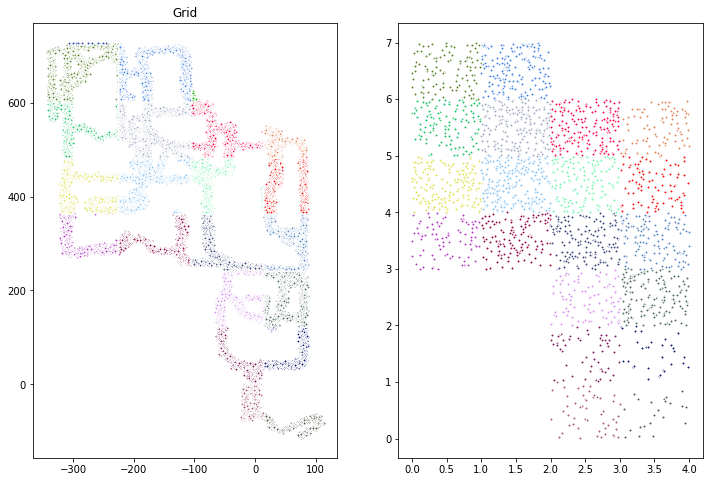

[1373, 6933, 8282, 8282, 5267, 16007, 21250, 21250, 19658, 35637, 39181, 32063, 43007, 63734, 59082, 40053, 58931, 83976, 71221, 41101, 58797, 75988, 58883, 26546, 34675, 44189, 34459, 14033, 14857, 14872, 9351, 16]


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pickle

class Grid:
    def __init__(self,grid_size=100.,overlap=50.,**kwargs):
        self.grid_size = grid_size
        self.overlap = overlap
        if 'data' in kwargs:
            data = kwargs['data']
            assert data.shape[1] == 2
            self.boundary_x = [np.min(data[:,0]), np.max(data[:,0])]
            self.boundary_y = [np.min(data[:,1]), np.max(data[:,1])]
            self.boundary_offset = [self.boundary_x[0],self.boundary_y[0]]
            self.num_grid_x,self.num_grid_y = self._cal_grid_num()
            self.num_grid = self.num_grid_x * self.num_grid_y
            self.weight = np.array([1, self.num_grid_x])
            self.weight_matrix = np.array([[1,self.num_grid_x,0,0],
                                           [1,0,0,self.num_grid_x],
                                           [0,self.num_grid_x,1,0],
                                           [0,0,1,self.num_grid_x]]).T
            self.grid_range_x,self.grid_range_y = self._cal_grid_range()
            self.save(os.path.join(args.model_dir,'grid.pkl'))
            print('Save Grids to',os.path.join(args.model_dir,'grid_{}_{}.pkl'.format(grid_size,overlap)))
        
    def _lenght(self):
        x_len = self.boundary_x[1] - self.boundary_x[0]
        y_len = self.boundary_y[1] - self.boundary_y[0]
        return x_len,y_len
    
    def _cal_grid_num(self):
        x_len,y_len = self._lenght()
        num_x_grid = math.ceil(x_len/self.grid_size)
        num_y_grid = math.ceil(y_len/self.grid_size)
        return num_x_grid,num_y_grid
    
    def _cal_grid_range(self):
        grid_range_x = list()
        grid_range_y = list()
        for x_inde in range(self.num_grid_x):
            x = x_inde*self.grid_size + self.boundary_x[0]
            grid_range_x.append([x-self.overlap,x+self.overlap+self.grid_size])

        for y_inde in range(self.num_grid_y):
            y = y_inde*self.grid_size + self.boundary_y[0]
            grid_range_y.append([y-self.overlap,y+self.overlap+self.grid_size])
        return np.array(grid_range_x),np.array(grid_range_y)
    
    def _grid_index(self,x,y):
        x_s = np.searchsorted(self.grid_range_x[:,1],x)
        x_s = min(max(x_s,0),self.num_grid_x-1)
        #x_index = [x_s,x_s+1] if x_s+1 < self.num_grid_x and self.grid_range_x[x_s+1,0] < x else [x_s,x_s]
        x_index = []
        for i in range(self.num_grid_x-x_s):
            if self.grid_range_x[x_s+i,0] < x:
                x_index.append(x_s + i)
        
        y_s = np.searchsorted(self.grid_range_y[:,1],y)
        y_s = min(max(y_s,0),self.num_grid_y-1)
        #y_index = [y_s,y_s+1] if y_s+1 < self.num_grid_y and self.grid_range_y[y_s+1,0] < y else [y_s,y_s]
        y_index = []
        for i in range(self.num_grid_y-y_s):
            if self.grid_range_y[y_s+i,0] < y:
                y_index.append(y_s + i)
        
        return x_index,y_index
    
    def in_grids(self,x,y):
        x_index,y_index = self._grid_index(x,y)
        #print(x_index,y_index)
        if len(x_index)<3:
            x_index += list(np.random.choice(len(x_index),3 - len(x_index)))
        if len(y_index)<3:
            y_index += list(np.random.choice(len(y_index),3 - len(y_index)))
        
        box = []
        for x_i in x_index:
            for y_i in y_index:
                box += [x_i+y_i*self.num_grid_x]
        return box
    
    def in_grids_exact_v(self,X):
        X = np.floor_divide(X - self.boundary_offset, self.grid_size)
        X = X @ self.weight
        return X
    def in_grids_exact_index_v(self,X):
        X = np.floor_divide(X - self.boundary_offset, self.grid_size)
        #X = X @ self.weight
        return X
    
    def in_grids_v(self,X):
        X = X - self.boundary_offset
        X_l = np.floor_divide(X - self.overlap, self.grid_size)
        X_l[X_l<0] = 0
        X_h = np.floor_divide(X + self.overlap, self.grid_size)
        X_h[:,0][X_h[:,0]>=self.num_grid_x] = self.num_grid_x -1
        X_h[:,1][X_h[:,1]>=self.num_grid_y] = self.num_grid_y -1
        out = np.hstack([X_l,X_h]) @ self.weight_matrix
        return out

    def save(self,filename = 'grid.pkl'):
        with open(filename,'wb') as f:
            f.write(pickle.dumps(self))

    def load(self,filename = 'grid.pkl'):
        with open(filename,'rb') as f:
            dataPickle = f.read()
            self = pickle.loads(dataPickle)
        
def draw(X,grid,seed=args.seed):
    #label_mask = grid.in_grids_v(X)
    #label_mask = np.zeros([X.shape[0],9])
    #for i in range(X.shape[0]):
    #    label_mask[i] = np.array(grid.in_grids(*X[i]))
    label_mask = grid.in_grids_exact_v(X).reshape(-1,1)

    np.random.seed(seed)
    r = lambda: np.random.randint(0,255)
    colors = ['#%02X%02X%02X' % (r(),r(),r()) for _ in range(grid.num_grid)]
    fig = plt.figure(figsize=(12, 8))
    
    ax = fig.add_subplot(1, 2, 1)
    for k, col in zip(range(grid.num_grid), colors):
        my_members = np.sum(label_mask == k,axis=1) >= 1
        ax.plot(X[my_members, 0], X[my_members, 1], 'w',
                markerfacecolor=col, marker='.')
    ax.set_title('Grid')
    #plt.show()
    
    dis = []
    for i in range(grid.num_grid):
        dis += [np.sum(np.sum(label_mask == i,axis=1)>=1)]
    
    ax = fig.add_subplot(1, 2, 2)
    for i,dense in enumerate(dis):
        row,line = divmod(i,grid.num_grid_x)
        x = np.random.rand(dense//50) + line
        y = np.random.rand(dense//50) + row
        ax.plot(x, y, 'w',markerfacecolor=colors[i], marker='.')
    plt.show()
    
    label_mask = np.zeros([X.shape[0],9])
    for i in range(X.shape[0]):
        label_mask[i] = np.array(grid.in_grids(*X[i]))
    
    dis = []
    for i in range(grid.num_grid):
        dis += [np.sum(np.sum(label_mask == i,axis=1)>=1)]
    
    
    return dis

grid = Grid(data=np.array(dataset.Targets)[:,:2],grid_size = 120., overlap=120.)
print('Grid_num:',grid.num_grid)

dis = draw(np.array(dataset.Targets)[:,:2],grid)
print(dis)

In [24]:
grid.grid_range_y + np.array([grid.overlap,-grid.overlap])

array([[-114.15,    5.85],
       [   5.85,  125.85],
       [ 125.85,  245.85],
       [ 245.85,  365.85],
       [ 365.85,  485.85],
       [ 485.85,  605.85],
       [ 605.85,  725.85],
       [ 725.85,  845.85]])

# Define Model

In [5]:
from torchlib.model import Backbone, NN, GP#, GPNode_local
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.likelihoods import BernoulliLikelihood

class BasicTrainer:
    def __init__(self,norm_mean,norm_std):
        self.model = None
        self.norm_mean = args.norm_mean.cuda()
        self.norm_std = args.norm_std.cuda()
        
    def disable_requires_grad(self,model):
        for param in model.parameters():
            param.requires_grad = False
            
    def load_model(self, file_name = 'pretrained.pth', strict = True):
        # load file info
        state_dict = torch.load(os.path.join(args.model_dir, file_name))
        if 'net.resnet.conv1.weight' in state_dict:
            print('Transform from old model.')
            # Part 1: backbone
            backbone_state_dict = self._from_old_model(state_dict,'backbone')
            print('Backbone parameters layer:',len(backbone_state_dict.keys()))
            self.model.backbone.load_state_dict(backbone_state_dict,strict = True)
            # Part 2: nn
            nn_state_dict = self._from_old_model(torch.load(os.path.join(args.model_dir, file_name)),'nn')
            print('NN parameters layer:',len(nn_state_dict.keys()))
            self.model.nn.load_state_dict(nn_state_dict,strict = strict)
        else:
            print('Parameters layer:',len(state_dict.keys()))
            # load file to model
            self.model.load_state_dict(state_dict,strict = strict)
        # Display model structure
        #print('Model Structure:')
        #for name, param in self.model.named_parameters():
        #    print(name, param.shape)
        print('Successfully loaded model...')
        print('Parameters layer:',len(self.model.state_dict().keys()))
    
    def _from_old_model(self, state_dict, select = 'backbone'):
        if select == 'backbone':
            for key in list(state_dict):
                if 'net.resnet.' in key:
                    state_dict[key.replace('net.resnet.','resnet.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        elif select == 'nn':
            for key in list(state_dict):
                if 'net.global_regressor.' in key:
                    state_dict[key.replace('net.global_regressor.','global_regressor.')] = state_dict.pop(key)
                elif 'net.global_context.' in key:
                    state_dict[key.replace('net.global_context.','global_context.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        return state_dict
    
    def save_model(self, file_name = 'model-{}-{}.pth'):
        checkpoint_path = os.path.join(args.model_dir, file_name)
        torch.save(self.model.state_dict(),checkpoint_path)
        print('Saving model to ' +  file_name)
        
    def show_require_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print (name, param.shape)

class GPNode_local(nn.Module):
    def __init__(self,inducing_points):
        super(GPNode_local,self).__init__()
        output_dim = inducing_points.shape[0] # 3-dim
        feat_dim = inducing_points.shape[-1]
        
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim) 
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output

class GPNode_global(nn.Module):
    def __init__(self,inducing_points_x,num_gp_x,inducing_points_y,num_gp_y):
        super(GPNode_global,self).__init__()
        #output_dim = inducing_points.shape[0] # num_gp
        #feat_dim = inducing_points.shape[-1]
        
        self.gp_x = GP(inducing_points_x,num_gp_x)
        self.likelihood_x = gpytorch.likelihoods.SoftmaxLikelihood(num_features=num_gp_x, num_classes=num_gp_x)
        
        self.gp_y = GP(inducing_points_y,num_gp_y)
        self.likelihood_y = gpytorch.likelihoods.SoftmaxLikelihood(num_features=num_gp_y, num_classes=num_gp_y)
        
    def forward(self,gp,input_data):
        output = gp(input_data)
        return output

class Model(nn.Module):
    def __init__(self,grid,p=0.4):
        super().__init__()
        self.num_gp = grid.num_grid
        self.dropout = nn.Dropout(p=p)
        self.bn = nn.BatchNorm1d(128)
        #self.active = nn.LeakyReLU(inplace=True)
        # Part 1: basic NN
        self.backbone = Backbone()
        self.nn = NN()
        # Part 2: global GP
        self.global_nn = nn.Linear(in_features=128,out_features=128)
        #inducing_points_x = torch.zeros(grid.num_grid_x, args.batch_size, args.feat_dim)
        inducing_points_x = torch.zeros(grid.num_grid_x, 300, args.feat_dim)
        #inducing_points_y = torch.zeros(grid.num_grid_y, args.batch_size, args.feat_dim)
        inducing_points_y = torch.zeros(grid.num_grid_y, 300, args.feat_dim)
        self.global_gp = GPNode_global(inducing_points_x,grid.num_grid_x,
                                       inducing_points_y,grid.num_grid_y)
        
        # Part 3: local GPs
        self.local_gps = nn.ModuleList()
        for i in range(self.num_gp):
            #inducing_points = torch.zeros(args.output_dim, args.batch_size, args.feat_dim)
            inducing_points = torch.zeros(args.output_dim, 300, args.feat_dim)
            gp = GPNode_local(inducing_points)
            self.local_gps.append(gp)
        
    def forward_nn(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention  
        #feature_t = self.bn(feature_t)
        #feature_t = self.active(feature_t)
        return feature_t, rot_pred
    
    def forward_gp(self,gp,trans_feat,dropout = False, global_nn = False):
        if global_nn:
            trans_feat = self.dropout(trans_feat)
            trans_feat = self.global_nn(trans_feat)
            trans_feat = self.bn(trans_feat)
            trans_feat = self.dropout(trans_feat)
        trans_pred = gp(trans_feat)
        return trans_pred

In [6]:
class Trainer(BasicTrainer):
    def __init__(self, grid, norm_mean, norm_std,
                 regressor_context_rate = [0.0,0.0],
                 is_training=True, disable_rot_learning = True, 
                 train_global_gp = True, train_local_gps = True):
        
        super().__init__(norm_mean, norm_std)
        self.model = Model(grid).cuda()
        self.grid = grid
        self.disable_rot_learning = disable_rot_learning
        self.train_global_gp = train_global_gp
        self.train_local_gps = train_local_gps
        
        self.disable_requires_grad(self.model.backbone)
        
        if is_training:
            # training tool
            self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
            self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                             lr_lambda=lambda epoch: args.decay_rate**epoch)
        else:
            self.disable_requires_grad(self.model)
            
    def _optimize(self,regressor_context_rate):
        optimizer = list()
        optimizer += [
            {'params': self.model.bn.parameters(), \
             'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        # Local GPs
        if self.train_local_gps:
            optimizer += [
                    {'params': self.model.local_gps.parameters(), \
                     'lr': args.learning_rate,'weight_decay':args.weight_decay}]            
        else:
            self.disable_requires_grad(self.model.local_gps)
            
        # Global GP
        if self.train_global_gp:
            optimizer += [{'params': self.model.global_gp.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
            optimizer += [{'params': self.model.global_nn.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        else:
            self.disable_requires_grad(self.model.global_gp)
            
        # NN
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            self.disable_requires_grad(self.model.nn.global_regressor)
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            self.disable_requires_grad(self.model.nn.global_context)
            
        if self.disable_rot_learning and regressor_context_rate[1]!=0.0:
            print("Warning: Set 'disable_rot_learning' to False")
            self.disable_rot_learning = False
        
        if self.disable_rot_learning and regressor_context_rate[1]==0.0:
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc1_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc2_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc3_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.logits_r)
                
        return optimizer
    
    def train(self,x,y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        start = time.time()
        
        if self.train_local_gps:
            #label = grid.in_grids_v(y[:,:2].numpy()) # n x 4
            label = np.zeros([y.shape[0],9]) # n x 9
            for i in range(y.shape[0]):
                label[i] = np.array(grid.in_grids(*y[i,:2]))
            #noise = np.random.choice(self.model.num_gp, y.shape[0], replace=True).reshape(-1,1)
            #noise = torch.randperm(y.shape[0]).view(-1,1)
            #label = np.hstack([label,noise])
        if self.train_global_gp:
            #label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
            #label_exact = torch.from_numpy(label_exact).cuda() # n x ,
            label_exact_index = grid.in_grids_exact_index_v(y[:,:2].numpy())
            label_exact_index = torch.from_numpy(label_exact_index).cuda()
            
        x,y = x.cuda(),y.cuda()
        
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std) # input should be 7 dim
            
        # Step 2: training
        assert self.model.training == True
        
        trans_loss = torch.tensor(0.).cuda()
        global_gp_loss = torch.tensor(0.).cuda()
        local_gps_loss = np.zeros(self.model.num_gp)
        
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        if not self.disable_rot_learning:
            rot_loss = self._nn_loss(rot_pred,rot_target)
        
        # Step 2-1: global GP classification
        if self.train_global_gp:
            num_data = min(len(dataloader)*args.batch_size,len(dataset))
            #global_gp_loss = self._gp_loss(self.model.global_gp,num_data,trans_feat,label_exact)
            global_gp_loss = self._gp_index_loss(self.model.global_gp,num_data,trans_feat,label_exact_index)
        
        # Step 2-2: local GPs regression
        if self.train_local_gps:
            num_batch_data = 0
            for i,gp in enumerate(self.model.local_gps):
                num_data = dis[i]
                if num_data > 0:
                    label_mask = np.sum(label == i,axis=1) >= 1
                    sub_x = trans_feat[label_mask]
                    sub_y = trans_target[label_mask] # unnormalized data 
                    if sub_y.shape[0]>0:
                        gp_loss = self._gp_loss(gp,num_data,sub_x,sub_y)
                        local_gps_loss[i] = float(gp_loss)
                        trans_loss += gp_loss * int(sub_y.shape[0])
                        num_batch_data += int(sub_y.shape[0])
            trans_loss = trans_loss/num_batch_data
        
        # Step 2-3: rotation 
        if not self.disable_rot_learning:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss + args.lamda_weights * rot_loss
            else:
                total_loss = trans_loss + args.lamda_weights * rot_loss
        else:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss
            else:
                total_loss = trans_loss
            
        #Step 3: update
        if self.train_global_gp or self.train_local_gps:
            total_loss.backward()
            self.optimizer.step()
        
        batch_time = time.time() - start
        return float(total_loss), float(global_gp_loss), local_gps_loss, batch_time
        
    def _nn_loss(self,rot_pred,rot_target):
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        return rot_loss
     
    def _gp_index_loss(self,gp,num_data,trans_feat,trans_target_index):
        trans_target_x = trans_target_index[:,0]
        trans_target_y = trans_target_index[:,1]
        
        #trans_pred_x = gp.forward(gp.gp_x, trans_feat)
        #trans_pred_y = gp.forward(gp.gp_y, trans_feat)
        trans_pred_x = self.model.forward_gp(gp.gp_x, trans_feat, dropout = True, global_nn = True)
        trans_pred_y = self.model.forward_gp(gp.gp_y, trans_feat, dropout = True, global_nn = True)
        
        mll_x = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood_x, gp.gp_x, 
                                            num_data=num_data).cuda()
        mll_y = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood_y, gp.gp_y, 
                                            num_data=num_data).cuda()
        
        gp_loss_x = -1.*mll_x(trans_pred_x, trans_target_x)
        gp_loss_y = -1.*mll_y(trans_pred_y, trans_target_y)
        
        loss = 0.5*gp_loss_x + 0.5*gp_loss_y
        return loss
        
    def _gp_loss(self,gp,num_data,trans_feat,trans_target):
        trans_pred = self.model.forward_gp(gp, trans_feat)
        #mll = gpytorch.mlls.VariationalELBO(gp.likelihood, gp.gp, 
        #                                    num_data=num_data).cuda()
        mll = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood, gp.gp, 
                                            num_data=num_data).cuda()
        
        trans_loss = -1.*mll(trans_pred, trans_target)
        return trans_loss
    
    def _eval_gp(self, gp, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = gp.likelihood(trans_pred).mean, gp.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def eval_classifier(self,x,y):
        label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
        label_exact = torch.from_numpy(label_exact).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            output = self.model.forward_gp(self.model.global_gp,trans_feat)
            output = self.model.global_gp.likelihood(output)
            pred = output.probs.mean(0).argmax(-1)
        return pred, label_exact    
    
    def eval_classifier_index(self,x,y):
        label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
        label_exact = torch.from_numpy(label_exact).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            output_x = self.model.forward_gp(self.model.global_gp.gp_x,trans_feat, dropout = True, global_nn = True)
            output_x = self.model.global_gp.likelihood_x(output_x)
            pred_x = output_x.probs.mean(0).argmax(-1)

            output_y = self.model.forward_gp(self.model.global_gp.gp_y,trans_feat, dropout = True, global_nn = True)
            output_y = self.model.global_gp.likelihood_y(output_y)
            pred_y = output_y.probs.mean(0).argmax(-1)
            
            pred = pred_x + pred_y*self.grid.num_grid_x
        return pred, label_exact
    
    def eval_forward(self,x,y,num_sample = 100, output_denormalize = True, label_from_gp = True):
        # Step 1: get data
        x,y = x.cuda(),y.cuda()
        
        if not label_from_gp:
            label = grid.in_grids_exact_v(y[:,:2].cpu().numpy()) # n x 4
        else:
            label,_ = self.eval_classifier(x.cpu(),y.cpu())
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()
        
        for i,gp in enumerate(self.model.local_gps):
            label_mask = label == i
            sub_x = trans_feat[label_mask]
            if sub_x.shape[0]>0:
                sub_trans_pred = self.model.forward_gp(gp,sub_x)
                sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
                if args.is_normalization and output_denormalize:
                    trans_pred[label_mask] = denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std)
                    trans_mean[label_mask] = denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std)
                    trans_var[label_mask] = sub_trans_var.mul(self.norm_std)
                else:
                    trans_pred[label_mask] = sub_trans_pred
                    trans_mean[label_mask] = sub_trans_mean
                    trans_var[label_mask] = sub_trans_var
                    
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples

args.learning_rate = 0.001
args.decay_rate = 0.75
args.save_every = 1000
   
trainer = Trainer(grid,args.norm_mean,args.norm_std,
                  regressor_context_rate = [0.0,0.0],
                  train_global_gp=True,train_local_gps=False,disable_rot_learning=True)

trainer.load_model('model-21-10000.pth',strict = True)
#trainer.load_model('pretrained_old.pth')
trainer.show_require_grad()

Parameters layer: 691
Successfully loaded model...
Parameters layer: 691
bn.weight torch.Size([128])
bn.bias torch.Size([128])
global_nn.weight torch.Size([128, 128])
global_nn.bias torch.Size([128])
global_gp.gp_x.variational_strategy.base_variational_strategy.inducing_points torch.Size([4, 300, 128])
global_gp.gp_x.variational_strategy.base_variational_strategy._variational_distribution.variational_mean torch.Size([4, 300])
global_gp.gp_x.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar torch.Size([4, 300, 300])
global_gp.gp_x.mean_module.constant torch.Size([4, 1])
global_gp.gp_x.covar_module.raw_outputscale torch.Size([4])
global_gp.gp_x.covar_module.base_kernel.raw_lengthscale torch.Size([4, 1, 1])
global_gp.likelihood_x.mixing_weights torch.Size([4, 4])
global_gp.gp_y.variational_strategy.base_variational_strategy.inducing_points torch.Size([8, 300, 128])
global_gp.gp_y.variational_strategy.base_variational_strategy._variational_dist

# Training

In [38]:
if args.tensorboard:
    import os
    os.system('rm -rf runs/class_gps')
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter('runs/class_gps')

## Training Epoch

In [39]:
if args.tensorboard:
    import os
    os.system('rm -rf runs/class_gps')
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter('runs/class_gps')

trainer.model.train()
for e in range(args.num_epochs):
#for e in range(4):
    train_loss = 0.
    for b, data in enumerate(dataloader, 0):
        x,y = data.values()
        
        single_loss, global_gp_loss, local_gps_loss, batch_time = trainer.train(x,y)
        
        with torch.no_grad():
            train_loss += single_loss
            if args.tensorboard:
                data2tensorboard(writer,single_loss,train_loss/(b+1),e*len(dataloader)+(b+1))
                if trainer.train_global_gp:
                    writer.add_scalars('global_gp_loss',
                       {'gp':global_gp_loss},e*len(dataloader)+(b+1))
                if trainer.train_local_gps:
                    writer.add_scalars('local_gps_loss',
                       {'gp'+str(i):local_gps_loss[i] for i in range(trainer.model.num_gp) if local_gps_loss[i] != 0},
                       e*len(dataloader)+(b+1))
            if ((b+1)%args.display == 0):
                display_loss(e*len(dataloader)+(b+1),args.num_epochs*len(dataloader),e,
                              train_loss/(b+1),batch_time,trainer.scheduler.get_last_lr()[0])          
            if (e * len(dataloader) + (b+1)) % args.save_every == 0:
                trainer.save_model('model-{}-{}.pth'.format(e, e * len(dataloader) + (b+1)))
            if trainer.scheduler.get_last_lr()[0] > args.learning_rate_clip and (e * len(dataloader) + (b+1)) % 200 == 0:
                trainer.scheduler.step()

10/91400 (epoch 0), train_loss = -7.98910489, time/batch = 1.784, learning rate = 0.00100000
20/91400 (epoch 0), train_loss = -8.13043673, time/batch = 1.783, learning rate = 0.00100000
30/91400 (epoch 0), train_loss = -8.19262875, time/batch = 1.784, learning rate = 0.00100000
40/91400 (epoch 0), train_loss = -8.23503028, time/batch = 1.785, learning rate = 0.00100000
50/91400 (epoch 0), train_loss = -8.26034188, time/batch = 1.781, learning rate = 0.00100000
60/91400 (epoch 0), train_loss = -8.27039894, time/batch = 1.797, learning rate = 0.00100000
70/91400 (epoch 0), train_loss = -8.28197361, time/batch = 1.782, learning rate = 0.00100000
80/91400 (epoch 0), train_loss = -8.29294133, time/batch = 1.778, learning rate = 0.00100000
90/91400 (epoch 0), train_loss = -8.30097845, time/batch = 1.785, learning rate = 0.00100000
100/91400 (epoch 0), train_loss = -8.30220334, time/batch = 1.782, learning rate = 0.00100000
110/91400 (epoch 0), train_loss = -8.30575545, time/batch = 1.777, le

897/91400 (epoch 1), train_loss = -8.46682827, time/batch = 1.779, learning rate = 0.00031641
907/91400 (epoch 1), train_loss = -8.46716442, time/batch = 1.783, learning rate = 0.00031641
924/91400 (epoch 2), train_loss = -8.50952444, time/batch = 1.778, learning rate = 0.00031641
934/91400 (epoch 2), train_loss = -8.51255608, time/batch = 1.776, learning rate = 0.00031641
944/91400 (epoch 2), train_loss = -8.51585662, time/batch = 1.771, learning rate = 0.00031641
954/91400 (epoch 2), train_loss = -8.51601331, time/batch = 1.774, learning rate = 0.00031641
964/91400 (epoch 2), train_loss = -8.51849461, time/batch = 1.779, learning rate = 0.00031641
974/91400 (epoch 2), train_loss = -8.51367146, time/batch = 1.782, learning rate = 0.00031641
984/91400 (epoch 2), train_loss = -8.51152596, time/batch = 1.790, learning rate = 0.00031641
994/91400 (epoch 2), train_loss = -8.51202297, time/batch = 1.782, learning rate = 0.00031641
Saving model to model-2-1000.pth
1004/91400 (epoch 2), train

1771/91400 (epoch 3), train_loss = -8.54407897, time/batch = 1.783, learning rate = 0.00010011
1781/91400 (epoch 3), train_loss = -8.54479023, time/batch = 1.779, learning rate = 0.00010011
1791/91400 (epoch 3), train_loss = -8.54521645, time/batch = 1.759, learning rate = 0.00010011
1801/91400 (epoch 3), train_loss = -8.54557427, time/batch = 1.776, learning rate = 0.00007508
1811/91400 (epoch 3), train_loss = -8.54545690, time/batch = 1.795, learning rate = 0.00007508
1821/91400 (epoch 3), train_loss = -8.54581033, time/batch = 1.776, learning rate = 0.00007508
1838/91400 (epoch 4), train_loss = -8.56781893, time/batch = 1.781, learning rate = 0.00007508
1848/91400 (epoch 4), train_loss = -8.56249013, time/batch = 1.781, learning rate = 0.00007508
1858/91400 (epoch 4), train_loss = -8.55854321, time/batch = 1.778, learning rate = 0.00007508
1868/91400 (epoch 4), train_loss = -8.56172957, time/batch = 1.784, learning rate = 0.00007508
1878/91400 (epoch 4), train_loss = -8.55984333, ti

2645/91400 (epoch 5), train_loss = -8.56891713, time/batch = 1.780, learning rate = 0.00002376
2655/91400 (epoch 5), train_loss = -8.56879518, time/batch = 1.792, learning rate = 0.00002376
2665/91400 (epoch 5), train_loss = -8.56876821, time/batch = 1.788, learning rate = 0.00002376
2675/91400 (epoch 5), train_loss = -8.56845165, time/batch = 1.786, learning rate = 0.00002376
2685/91400 (epoch 5), train_loss = -8.56818486, time/batch = 1.782, learning rate = 0.00002376
2695/91400 (epoch 5), train_loss = -8.56802290, time/batch = 1.783, learning rate = 0.00002376
2705/91400 (epoch 5), train_loss = -8.56752462, time/batch = 1.793, learning rate = 0.00002376
2715/91400 (epoch 5), train_loss = -8.56804035, time/batch = 1.780, learning rate = 0.00002376
2725/91400 (epoch 5), train_loss = -8.56819748, time/batch = 1.815, learning rate = 0.00002376
2735/91400 (epoch 5), train_loss = -8.56804963, time/batch = 1.780, learning rate = 0.00002376
2752/91400 (epoch 6), train_loss = -8.57841015, ti

3519/91400 (epoch 7), train_loss = -8.57440946, time/batch = 1.787, learning rate = 0.00000752
3529/91400 (epoch 7), train_loss = -8.57470643, time/batch = 1.783, learning rate = 0.00000752
3539/91400 (epoch 7), train_loss = -8.57446940, time/batch = 1.782, learning rate = 0.00000752
3549/91400 (epoch 7), train_loss = -8.57459324, time/batch = 1.787, learning rate = 0.00000752
3559/91400 (epoch 7), train_loss = -8.57523342, time/batch = 1.776, learning rate = 0.00000752
3569/91400 (epoch 7), train_loss = -8.57517437, time/batch = 1.785, learning rate = 0.00000752
3579/91400 (epoch 7), train_loss = -8.57526333, time/batch = 1.781, learning rate = 0.00000752
3589/91400 (epoch 7), train_loss = -8.57525289, time/batch = 1.796, learning rate = 0.00000752
3599/91400 (epoch 7), train_loss = -8.57493885, time/batch = 1.781, learning rate = 0.00000752
3609/91400 (epoch 7), train_loss = -8.57480144, time/batch = 1.779, learning rate = 0.00000564
3619/91400 (epoch 7), train_loss = -8.57461884, ti

4393/91400 (epoch 9), train_loss = -8.57578947, time/batch = 1.787, learning rate = 0.00000238
4403/91400 (epoch 9), train_loss = -8.57616603, time/batch = 1.783, learning rate = 0.00000178
4413/91400 (epoch 9), train_loss = -8.57550092, time/batch = 1.783, learning rate = 0.00000178
4423/91400 (epoch 9), train_loss = -8.57594163, time/batch = 1.769, learning rate = 0.00000178
4433/91400 (epoch 9), train_loss = -8.57588899, time/batch = 1.803, learning rate = 0.00000178
4443/91400 (epoch 9), train_loss = -8.57606538, time/batch = 1.784, learning rate = 0.00000178
4453/91400 (epoch 9), train_loss = -8.57629172, time/batch = 1.777, learning rate = 0.00000178
4463/91400 (epoch 9), train_loss = -8.57601827, time/batch = 1.781, learning rate = 0.00000178
4473/91400 (epoch 9), train_loss = -8.57561779, time/batch = 1.789, learning rate = 0.00000178
4483/91400 (epoch 9), train_loss = -8.57600024, time/batch = 1.788, learning rate = 0.00000178
4493/91400 (epoch 9), train_loss = -8.57653774, ti

5267/91400 (epoch 11), train_loss = -8.57687916, time/batch = 1.790, learning rate = 0.00000056
5277/91400 (epoch 11), train_loss = -8.57716881, time/batch = 1.790, learning rate = 0.00000056
5287/91400 (epoch 11), train_loss = -8.57722367, time/batch = 1.800, learning rate = 0.00000056
5297/91400 (epoch 11), train_loss = -8.57662159, time/batch = 1.805, learning rate = 0.00000056
5307/91400 (epoch 11), train_loss = -8.57589138, time/batch = 1.778, learning rate = 0.00000056
5317/91400 (epoch 11), train_loss = -8.57606041, time/batch = 1.801, learning rate = 0.00000056
5327/91400 (epoch 11), train_loss = -8.57675556, time/batch = 1.776, learning rate = 0.00000056
5337/91400 (epoch 11), train_loss = -8.57697489, time/batch = 1.787, learning rate = 0.00000056
5347/91400 (epoch 11), train_loss = -8.57671056, time/batch = 1.785, learning rate = 0.00000056
5357/91400 (epoch 11), train_loss = -8.57711931, time/batch = 1.774, learning rate = 0.00000056
5367/91400 (epoch 11), train_loss = -8.5

6131/91400 (epoch 13), train_loss = -8.57589482, time/batch = 1.787, learning rate = 0.00000018
6141/91400 (epoch 13), train_loss = -8.57554980, time/batch = 1.808, learning rate = 0.00000018
6151/91400 (epoch 13), train_loss = -8.57511119, time/batch = 1.787, learning rate = 0.00000018
6161/91400 (epoch 13), train_loss = -8.57554931, time/batch = 1.795, learning rate = 0.00000018
6171/91400 (epoch 13), train_loss = -8.57520621, time/batch = 1.780, learning rate = 0.00000018
6181/91400 (epoch 13), train_loss = -8.57532235, time/batch = 1.781, learning rate = 0.00000018
6191/91400 (epoch 13), train_loss = -8.57490592, time/batch = 1.789, learning rate = 0.00000018
6201/91400 (epoch 13), train_loss = -8.57491588, time/batch = 1.787, learning rate = 0.00000013
6211/91400 (epoch 13), train_loss = -8.57537273, time/batch = 1.780, learning rate = 0.00000013
6221/91400 (epoch 13), train_loss = -8.57608629, time/batch = 1.790, learning rate = 0.00000013
6231/91400 (epoch 13), train_loss = -8.5

Saving model to model-15-7000.pth
7005/91400 (epoch 15), train_loss = -8.58132961, time/batch = 1.779, learning rate = 0.00000008
7015/91400 (epoch 15), train_loss = -8.58197713, time/batch = 1.780, learning rate = 0.00000008
7025/91400 (epoch 15), train_loss = -8.58066783, time/batch = 1.786, learning rate = 0.00000008
7035/91400 (epoch 15), train_loss = -8.58098276, time/batch = 1.776, learning rate = 0.00000008
7045/91400 (epoch 15), train_loss = -8.58040948, time/batch = 1.785, learning rate = 0.00000008
7055/91400 (epoch 15), train_loss = -8.58015794, time/batch = 1.781, learning rate = 0.00000008
7065/91400 (epoch 15), train_loss = -8.57991308, time/batch = 1.788, learning rate = 0.00000008
7075/91400 (epoch 15), train_loss = -8.57905332, time/batch = 1.776, learning rate = 0.00000008
7085/91400 (epoch 15), train_loss = -8.57893955, time/batch = 1.779, learning rate = 0.00000008
7095/91400 (epoch 15), train_loss = -8.57879724, time/batch = 1.782, learning rate = 0.00000008
7105/9

7869/91400 (epoch 17), train_loss = -8.58318907, time/batch = 1.780, learning rate = 0.00000008
7879/91400 (epoch 17), train_loss = -8.58267557, time/batch = 1.797, learning rate = 0.00000008
7889/91400 (epoch 17), train_loss = -8.58286046, time/batch = 1.774, learning rate = 0.00000008
7899/91400 (epoch 17), train_loss = -8.58305747, time/batch = 1.776, learning rate = 0.00000008
7909/91400 (epoch 17), train_loss = -8.58259907, time/batch = 1.782, learning rate = 0.00000008
7919/91400 (epoch 17), train_loss = -8.58273177, time/batch = 1.790, learning rate = 0.00000008
7929/91400 (epoch 17), train_loss = -8.58216652, time/batch = 1.803, learning rate = 0.00000008
7939/91400 (epoch 17), train_loss = -8.58140925, time/batch = 1.782, learning rate = 0.00000008
7949/91400 (epoch 17), train_loss = -8.58108274, time/batch = 1.788, learning rate = 0.00000008
7959/91400 (epoch 17), train_loss = -8.58063268, time/batch = 1.761, learning rate = 0.00000008
7969/91400 (epoch 17), train_loss = -8.5

8733/91400 (epoch 19), train_loss = -8.57513565, time/batch = 1.795, learning rate = 0.00000008
8743/91400 (epoch 19), train_loss = -8.57846142, time/batch = 1.822, learning rate = 0.00000008
8753/91400 (epoch 19), train_loss = -8.57568363, time/batch = 1.783, learning rate = 0.00000008
8763/91400 (epoch 19), train_loss = -8.57566322, time/batch = 1.773, learning rate = 0.00000008
8773/91400 (epoch 19), train_loss = -8.57538005, time/batch = 1.779, learning rate = 0.00000008
8783/91400 (epoch 19), train_loss = -8.57658642, time/batch = 1.782, learning rate = 0.00000008
8793/91400 (epoch 19), train_loss = -8.57605258, time/batch = 1.788, learning rate = 0.00000008
8803/91400 (epoch 19), train_loss = -8.57619834, time/batch = 1.774, learning rate = 0.00000008
8813/91400 (epoch 19), train_loss = -8.57537145, time/batch = 1.805, learning rate = 0.00000008
8823/91400 (epoch 19), train_loss = -8.57554082, time/batch = 1.781, learning rate = 0.00000008
8833/91400 (epoch 19), train_loss = -8.5

9590/91400 (epoch 20), train_loss = -8.57790217, time/batch = 1.747, learning rate = 0.00000008
9607/91400 (epoch 21), train_loss = -8.56262465, time/batch = 1.797, learning rate = 0.00000008
9617/91400 (epoch 21), train_loss = -8.56395569, time/batch = 1.784, learning rate = 0.00000008
9627/91400 (epoch 21), train_loss = -8.57186848, time/batch = 1.783, learning rate = 0.00000008
9637/91400 (epoch 21), train_loss = -8.57499824, time/batch = 1.787, learning rate = 0.00000008
9647/91400 (epoch 21), train_loss = -8.57658329, time/batch = 1.775, learning rate = 0.00000008
9657/91400 (epoch 21), train_loss = -8.57864834, time/batch = 1.780, learning rate = 0.00000008
9667/91400 (epoch 21), train_loss = -8.57881238, time/batch = 1.791, learning rate = 0.00000008
9677/91400 (epoch 21), train_loss = -8.57653446, time/batch = 1.783, learning rate = 0.00000008
9687/91400 (epoch 21), train_loss = -8.57615751, time/batch = 1.780, learning rate = 0.00000008
9697/91400 (epoch 21), train_loss = -8.5

10454/91400 (epoch 22), train_loss = -8.57841437, time/batch = 1.786, learning rate = 0.00000008
10464/91400 (epoch 22), train_loss = -8.57863557, time/batch = 1.778, learning rate = 0.00000008
10474/91400 (epoch 22), train_loss = -8.57866644, time/batch = 1.750, learning rate = 0.00000008
10484/91400 (epoch 22), train_loss = -8.57881779, time/batch = 1.790, learning rate = 0.00000008
10494/91400 (epoch 22), train_loss = -8.57878169, time/batch = 1.781, learning rate = 0.00000008
10504/91400 (epoch 22), train_loss = -8.57889546, time/batch = 1.796, learning rate = 0.00000008
10521/91400 (epoch 23), train_loss = -8.59165325, time/batch = 1.773, learning rate = 0.00000008
10531/91400 (epoch 23), train_loss = -8.58896265, time/batch = 1.783, learning rate = 0.00000008
10541/91400 (epoch 23), train_loss = -8.58683201, time/batch = 1.791, learning rate = 0.00000008
10551/91400 (epoch 23), train_loss = -8.59012268, time/batch = 1.788, learning rate = 0.00000008
10561/91400 (epoch 23), train_

KeyboardInterrupt: 

# Evaluation

In [40]:
from torch.distributions import Normal
trainer.model.eval()

for b, data in enumerate(dataloader, 0):
    x,y = data.values()
    trans_pred, rot_pred, trans_target, rot_target, samples = trainer.eval_forward(x,y,label_from_gp=False)
    break

In [41]:
trans_pred

tensor([[  -319.5134,    616.0941,    -14.0689],
        [   -30.4977,    508.4311,     -1.7754],
        [   -76.2905,    457.1803,    -10.6873],
        [  -117.5876,    581.2910,    -11.9303],
        [  -262.0363,    531.1591,    -11.5969],
        [   -46.6206,    509.3494,     -1.2724],
        [    55.1594,    311.3699,     -1.6717],
        [   -46.6942,    253.5182,     -6.7578],
        [   -42.8019,    552.0585,    -11.5474],
        [  -114.4564,    479.8063,    -11.3437],
        [  -312.6006,    609.7897,    -13.9909],
        [    37.6994,    473.9689,     -2.4239],
        [   -51.6800,    546.1937,    -11.4586],
        [  -154.8161,    581.8851,    -11.9449],
        [    -1.7525,    238.2648,     -5.5056],
        [  -220.3000,    611.9980,    -12.1531],
        [    71.6397,    298.3755,     -1.7874],
        [    67.7358,    313.7308,     -1.7869],
        [    37.0634,    465.7278,     -2.4199],
        [  -148.7220,    515.6066,    -11.8815],
        [   -14.2676

In [42]:
trans_target

tensor([[  -318.0151,    617.4789,    -14.0580],
        [   -30.7768,    509.2065,     -1.7930],
        [   -75.9838,    456.5378,    -10.6945],
        [  -117.5740,    581.8989,    -11.9216],
        [  -262.7999,    531.9617,    -11.6044],
        [   -47.4519,    509.4013,     -1.1846],
        [    55.4520,    312.8643,     -1.6664],
        [   -47.7051,    251.9474,     -6.8132],
        [   -42.6526,    551.2410,    -11.5592],
        [  -112.4794,    478.6029,    -11.3242],
        [  -311.2226,    612.0449,    -14.0327],
        [    39.8174,    472.0428,     -2.4436],
        [   -51.4663,    545.7432,    -11.4512],
        [  -156.6401,    581.1888,    -11.9633],
        [    -3.4257,    237.6876,     -5.5235],
        [  -219.5481,    611.7574,    -12.1535],
        [    71.6275,    297.8702,     -1.7930],
        [    68.3284,    313.1365,     -1.7405],
        [    36.6486,    464.3792,     -2.4432],
        [  -148.7198,    514.5189,    -11.9500],
        [   -14.6740

In [7]:
from torch.distributions import Normal
trainer.model.eval()

accs = 0
error_num = 0
for b, data in enumerate(dataloader, 0):
    x,y = data.values()
    pred, target = trainer.eval_classifier_index(x,y)
    acc = float(torch.sum(pred - target == 0))/float(target.shape[0])
    gt = target[pred - target != 0].cpu().numpy()
    offset = (pred - target)[pred - target != 0].cpu().numpy()
    pt = pred[pred - target != 0].cpu().numpy()
    if len(offset)>0 and np.abs(offset).max() > 5:
        print(np.vstack([gt,offset,pt]))
        print(offset[np.abs(offset)>5])
        num = len(offset[np.abs(offset)>5])
        error_num += num
        print("Error number:",num)
    accs += acc
    if b % 10 == 0:
        print(acc)
    if b % 100 == 0 and b != 0:
        break
print("ACC:", accs/(b+1))
print('Total error number:',error_num)

0.9714285714285714
0.9678571428571429
0.975
0.9642857142857143
0.9892857142857143
0.9678571428571429
0.9714285714285714
0.9714285714285714
0.9821428571428571
0.9857142857142858
0.9714285714285714
ACC: 0.9756718528995754
Total error number: 0
